In [10]:
from kan import *
import torch
from torch import autograd
from tqdm import tqdm
from pyscf import gto, scf
from collections import Counter


#%pip install ipympl
%pip install --upgrade jupyter matplotlib ipympl
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipympl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
#  # testing if 
# x = torch.zeros(train_num, 2)
# x[:, 0] = 20 * torch.rand(train_num)  # Random numbers from 0 to 20
# x[:, 1] = torch.pi * torch.rand(train_num) # Random numbers from 0 to π
# x

# # create dataset


# def create_dataset(train_num=10000, test_num=10000):

#     def generate_contrastive(x):
#         # positive samples
#         batch = x.shape[0]
#         x[:,0] = (1 / torch.sqrt(32 * torch.pi)) * x[:,[0]] * torch.exp((-1/2) * x[:,[0]])
#         x[:,1] = torch.cos(x[:,[1]] * torch.pi/20)

#         # negative samples
#         def corrupt(tensor):
#             y = copy.deepcopy(tensor)
#             for i in range(y.shape[1]):
#                 y[:,i] = y[:,i][torch.randperm(y.shape[0])]
#             return y

#         x_cor = corrupt(x)
#         x = torch.cat([x, x_cor], dim=0)
#         y = torch.cat([torch.ones(batch,), torch.zeros(batch,)], dim=0)[:,None]
#         return x, y

#     x = torch.rand(train_num, 6) * 2 - 1
#     x_train, y_train = generate_contrastive(x)

#     x = torch.rand(test_num, 6) * 2 - 1
#     x_test, y_test = generate_contrastive(x)

#     dataset = {}
#     dataset['train_input'] = x_train.to(device)
#     dataset['test_input'] = x_test.to(device)
#     dataset['train_label'] = y_train.to(device)
#     dataset['test_label'] = y_test.to(device)
#     return dataset

# dataset = create_dataset()

In [11]:
# Total number of electrons
total_electrons = 1
total_electrons

NUM_ELECTRONS = total_electrons
INPUT_DIM = NUM_ELECTRONS
OUTPUT_DIM = NUM_ELECTRONS

# Create dataset
f = lambda x: (1 / torch.sqrt(torch.tensor(32.0 * torch.pi))) * x[:,[0]] * torch.exp((-1/2) * x[:,[0]]) * torch.sin(x[:,[1]] * torch.pi/20) * torch.cos(x[:,[2]] * torch.pi/20)
dataset = create_dataset(f, n_var=3, ranges=[0,20], train_num=3000, test_num=3000)
print("Dataset shapes:", dataset['train_input'].shape, dataset['train_label'].shape)

Dataset shapes: torch.Size([3000, 3]) torch.Size([3000, 1])


In [191]:
# plt.figure(figsize=(10, 6))
# x = dataset['train_input'][:,1]
# x_1 = dataset['train_input'][:,0]
# y = dataset['train_label'][:].detach().cpu().numpy().flatten()
# plt.scatter(x, y, alpha=0.5, s=1)
# plt.scatter(x_1, y, alpha=0.5, s=1, c='green')
# #plt.scatter(np.arange(0, 20, 20/len(x_1)), x_1/200, s=1)
# plt.xlabel('x')
# plt.ylabel('Value')
# plt.show()
# print(dataset['train_input'][:,0].max() - dataset['train_input'][:,0].numpy().min())

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np

# Extract radial and angular components
func = dataset['train_label'][:].detach().cpu().numpy().flatten()  # full function
r = func
theta = dataset['train_input'][:,1].detach().cpu().numpy().flatten() * np.pi / 20 # angular for theta, i.e. polar angle down from z-axis
phi = 2 * torch.pi * torch.rand(r.shape[0]).numpy().flatten()

print(r.max(), r.min(), 'theta', theta.min(), theta.max(), 'phi', phi.min(), phi.max())
# Convert to Cartesian coordinates
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r

# # Scale to -5 to 5 range
# def scale_to_range(arr, min_val=-5, max_val=5):
#     return (max_val - min_val) * (arr - arr.min()) / (arr.max() - arr.min()) + min_val

# x = scale_to_range(x)
# y = scale_to_range(y)
# z = scale_to_range(z)

# Create DataFrame
df = pd.DataFrame({
    'X': x,
    'Y': y,
    'Z': z
})

fig = px.scatter_3d(df, 
                    x='X', 
                    y='Y', 
                    z='Z',
                    color='Z',
                    color_continuous_scale='viridis',
                    opacity=0.6,
                    title='3D Plot in Cartesian Coordinates')

# Set axis ranges
# fig.update_layout(scene=dict(
#     xaxis=dict(range=[-0.08, 0.08]),
#     yaxis=dict(range=[-0.08, 0.08]),
#     zaxis=dict(range=[-0.08, 0.08])
# ))

fig.update_traces(marker=dict(size=2))  # Uniform size for all markers
fig.show()

0.07146541 -0.06908788 theta 0.00037207274 3.1410768 phi 0.004636397 6.2825494


In [233]:
# Create MultKAN model with specified widths
# Create the initial MultKAN model
model = MultKAN(width=[2,[0,1]], grid=5, k=4, seed=42, mult_arity=2, base_fun='identity')
#model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

checkpoint directory created: ./model
saving model version 0.0


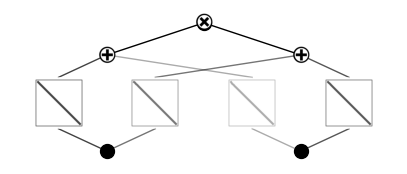

In [234]:
model(dataset['train_input'])
model.plot(beta=1)

saving model version 0.1


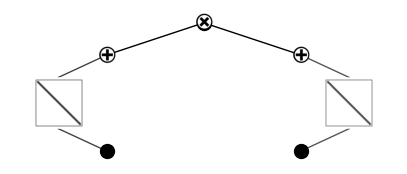

In [235]:
model.module(0, '[1]->[1]')
#model.fix_symbolic(1,0,0, '0',fit_params_bool=False)
model.plot(beta=1)

In [236]:
model.fit(dataset, steps=100)#, lamb=0.001)

| train_loss: 1.91e-03 | test_loss: 1.87e-03 | reg: 1.44e+00 | : 100%|█| 100/100 [00:08<00:00, 11.81

saving model version 0.2


{'train_loss': [array(0.11695606, dtype=float32),
  array(0.04073884, dtype=float32),
  array(0.03149186, dtype=float32),
  array(0.02186467, dtype=float32),
  array(0.02051369, dtype=float32),
  array(0.0199131, dtype=float32),
  array(0.01941053, dtype=float32),
  array(0.01916278, dtype=float32),
  array(0.01913046, dtype=float32),
  array(0.01909872, dtype=float32),
  array(0.01906278, dtype=float32),
  array(0.0189553, dtype=float32),
  array(0.01879748, dtype=float32),
  array(0.01873592, dtype=float32),
  array(0.01858642, dtype=float32),
  array(0.01854894, dtype=float32),
  array(0.01848626, dtype=float32),
  array(0.01844014, dtype=float32),
  array(0.01835044, dtype=float32),
  array(0.01829312, dtype=float32),
  array(0.01812376, dtype=float32),
  array(0.01802444, dtype=float32),
  array(0.01777879, dtype=float32),
  array(0.0176099, dtype=float32),
  array(0.01749675, dtype=float32),
  array(0.01745076, dtype=float32),
  array(0.0174369, dtype=float32),
  array(0.01741382

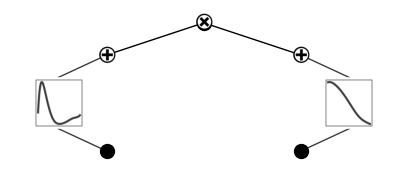

In [238]:
model.plot(beta=1)

In [239]:
grids = np.array([3,10,20])

train_losses = []
test_losses = []
steps = 50

for i in range(grids.shape[0]):
        model = model.refine(grids[i])
        results = model.fit(dataset, opt="LBFGS", steps=steps)
        train_losses += results['train_loss']
        test_losses += results['test_loss']

saving model version 0.3


| train_loss: 6.05e-03 | test_loss: 5.82e-03 | reg: 1.44e+00 | : 100%|█| 50/50 [00:02<00:00, 20.13it


saving model version 0.4
saving model version 0.5


| train_loss: 5.13e-04 | test_loss: 5.05e-04 | reg: 1.51e+00 | : 100%|█| 50/50 [00:04<00:00, 10.90it


saving model version 0.6
saving model version 0.7


| train_loss: 1.69e-04 | test_loss: 1.72e-04 | reg: 1.51e+00 | : 100%|█| 50/50 [00:04<00:00, 11.85it


saving model version 0.8


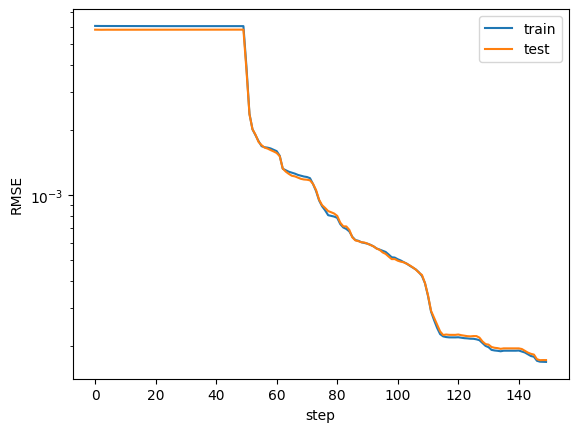

In [240]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

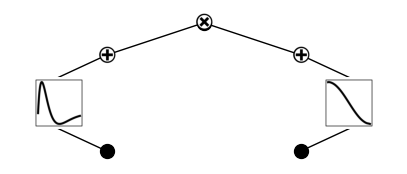

In [241]:
model.plot()

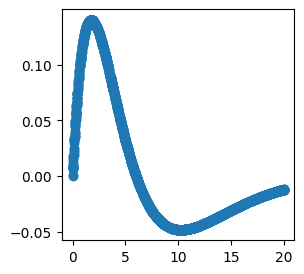

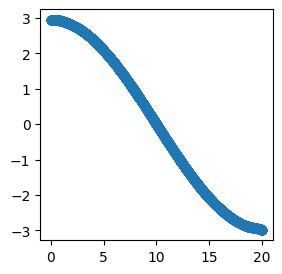

In [242]:
function_1 = np.array(model.get_fun(0,0,0))
function_2 = np.array(model.get_fun(0,1,1))
#function_3 = np.array(model.get_fun(1,0,0))

In [243]:
total_fun2 = function_1[1] * function_2[1]# + function_3[1]
total_fun1 = function_1[0]

In [21]:
model.unfix_symbolic_all()

saving model version 0.10
saving model version 0.11
saving model version 0.12
saving model version 0.13


In [ ]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,1,'x')
    model.fix_symbolic(0,0,1,'exp')
elif mode == "auto":
    # automatic mode
    #lib = ['x','exp', 'x^2']
    model.auto_symbolic()

In [ ]:
sf = model.symbolic_formula()[0][0]

In [ ]:
nsimplify(ex_round(ex_round(sf, 3),3))

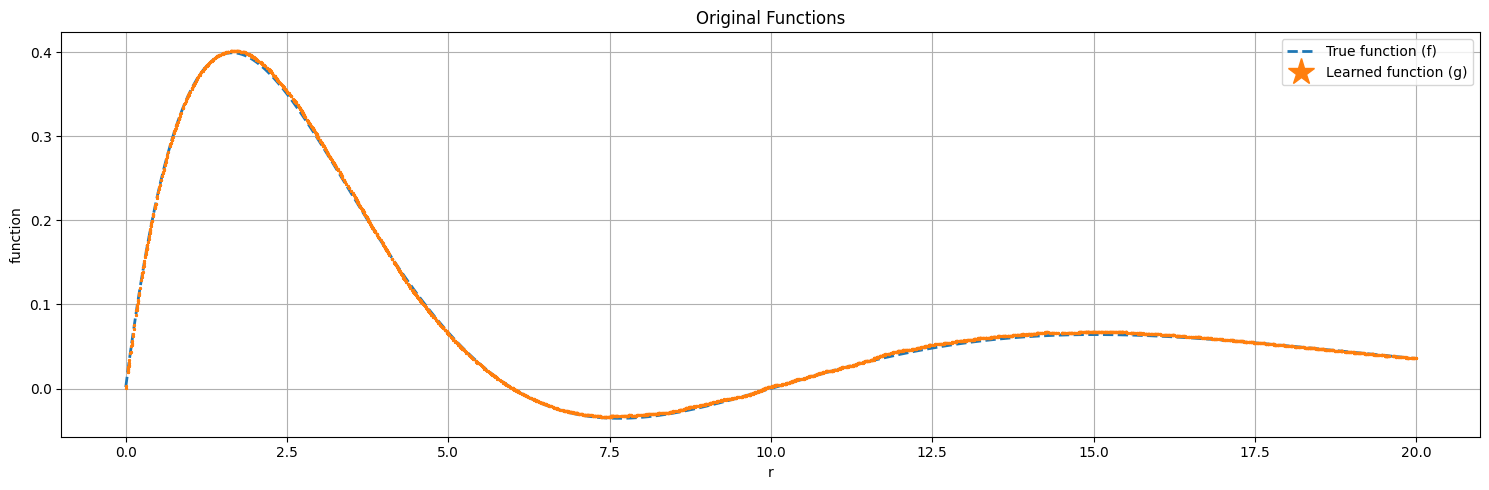

In [245]:
x = total_fun1.reshape(-1, 1)
y = total_fun1.reshape(-1, 1)
#x_test = torch.ones(r.shape[0]).numpy().flatten() * 20

f = (1 / np.sqrt(32.0 * np.pi)) * (6*x - x**2) * np.exp((-1/3) * x) * np.cos(x * np.pi/20)
g = total_fun2.reshape(-1, 1)
#h = total_fun1.reshape(-1, 1) * np.pi / 20
h = dataset['train_input'][:,1].detach().cpu().numpy().flatten() * np.pi / 400

# Create subplots
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))

# Regular functions plot
ax1.plot(x, f, '--', label='True function (f)', linewidth=2)
ax1.plot(x, g, '*', label='Learned function (g)', linewidth=1, markersize=2)
#ax1.plot(x, h, '*', label='Learned function (g)', linewidth=1, markersize=2)
ax1.set_xlabel('r')
ax1.set_ylabel('function')
ax1.set_title('Original Functions')
ax1.legend(markerscale=10)
ax1.grid(True)


plt.tight_layout()
plt.show()

In [ ]:
mse = np.mean((f - g) ** 2)
print(f"Mean Squared Error: {mse:.10f}")

Mean Squared Error: 0.0025733844


In [253]:
import plotly.express as px
import pandas as pd
import numpy as np

# Extract radial and angular components
f_rt = total_fun2 # gives function curve
phi = np.random.rand(f_rt.shape[0]) * torch.pi * 2
theta = np.random.rand(f_rt.shape[0]) * torch.pi
r = f_rt * np.cos(theta) # radial values given by function curve mulitplied by cos(theta) where theta between 0 and pi
#r_1 = f_rt * np.sin(theta) # radial values given by function curve mulitplied by cos(theta) where theta between 0 and pi

# Convert to Cartesian coordinates
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r

# # Scale to -5 to 5 range
# def scale_to_range(arr, min_val=-5, max_val=5):
#     return (max_val - min_val) * (arr - arr.min()) / (arr.max() - arr.min()) + min_val

# x = scale_to_range(x)
# y = scale_to_range(y)
# z = scale_to_range(z)

# Create DataFrame
df = pd.DataFrame({
    'X': x,
    'Y': y,
    'Z': z
})

fig = px.scatter_3d(df, 
                    x='X', 
                    y='Y', 
                    z='Z',
                    color='Z',
                    color_continuous_scale='viridis',
                    opacity=0.6,
                    title='3D Plot in Cartesian Coordinates')

# Set axis ranges
# fig.update_layout(scene=dict(
#     xaxis=dict(range=[-0.08, 0.08]),
#     yaxis=dict(range=[-0.08, 0.08]),
#     zaxis=dict(range=[-0.08, 0.08])
# ))

fig.update_traces(marker=dict(size=2))  # Uniform size for all markers
fig.show()

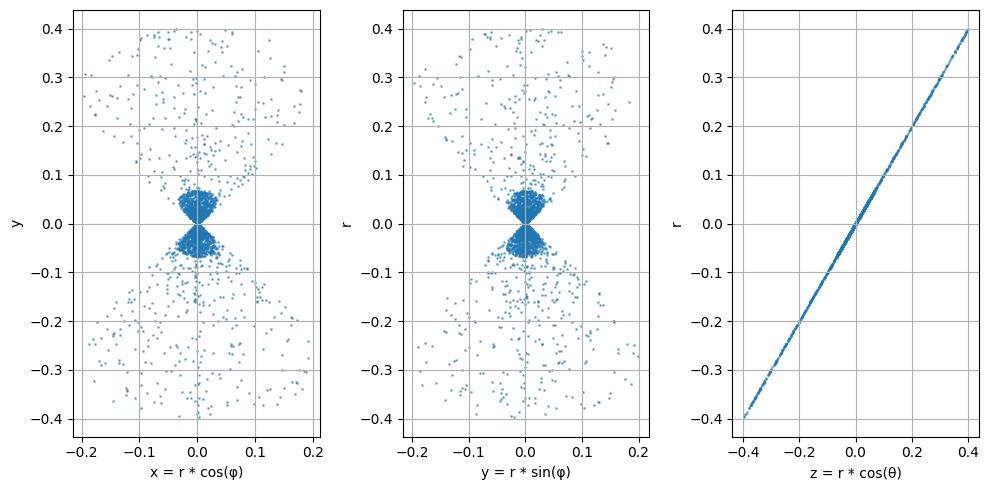

In [254]:
# Create three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

# Plot x = r * cos(phi)
ax1.scatter(x, r, alpha=0.5, s=1)
ax1.set_ylabel('y')
ax1.set_xlabel('x = r * cos(φ)')
ax1.grid(True)

# Plot y = r * sin(phi)
ax2.scatter(y, r, alpha=0.5, s=1)
ax2.set_ylabel('r')
ax2.set_xlabel('y = r * sin(φ)')
ax2.grid(True)

# Plot z = r * cos(π/2 - θ)
ax3.scatter(z, r, alpha=0.5, s=1)
ax3.set_ylabel('r')
ax3.set_xlabel('z = r * cos(θ)')
ax3.grid(True)

plt.tight_layout()
plt.show()

In [220]:

# plt.figure(figsize=(10, 6))
# index = total_fun1.reshape(-1, 1)# == index = np.arange(len(z)) for plotting
# x_1 = dataset['train_input'][:,0]
# x_0 = dataset['train_input'][:,1]
# theta_0 = np.array(x_0*np.pi/20)
# x = r * np.sin(theta_0) * np.cos(phi)
# y = r * np.sin(theta_0) * np.sin(phi)
# z = r * np.cos(theta_0)

# # x_1 = dataset['train_input'][:,0]
# # y = dataset['train_label'][:].detach().cpu().numpy().flatten()
# #x = dataset['train_input'][:,1]
# #plt.scatter(x_1, z, alpha=0.5, s=1, c='green')
# plt.scatter(index, f_rt * np.cos(theta_0), alpha=0.5, s=1, c='green')
# plt.scatter(x_0, z, alpha=0.5, s=1, c='blue')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.show()
# print(len(z))